In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
env = gym.make('CartPole-v1').unwrapped

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, *args):
      if len(self.memory) < self.capacity:
        self.memory.append(None)
      self.memory[self.position] = Transition(*args)
      self.position = (self.position + 1) % self.capacity
    def sample(self, batch_size):
      return random.sample(self.memory, batch_size)
    def __len__(self):
      return len(self.memory)


In [4]:
class DQN(nn.Module):
  def __init__(self, h, w, outputs):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.bn3 = nn.BatchNorm2d(32)

    def con2d_size_out(size, kernel_size = 5, stride = 2):
      return (size - (kernel_size - 1) - 1) // stride  + 1

    convw = con2d_size_out(con2d_size_out(con2d_size_out(w)))
    convh = con2d_size_out(con2d_size_out(con2d_size_out(h)))
    linear_input_size = convw * convh * 32
    self.head = nn.Linear(linear_input_size, outputs)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    return self.head(x.view(x.size(0), -1))

In [5]:
model = DQN(40, 60, 2).to(device)
print(model)

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=256, out_features=2, bias=True)
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 18.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


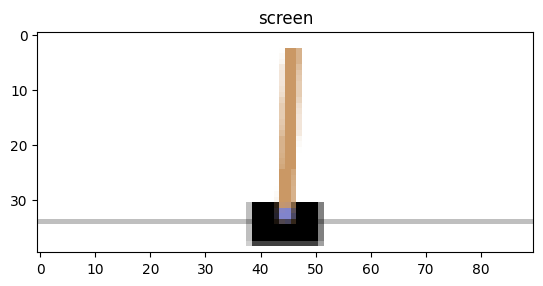

In [6]:
!pip install pyglet
import pyglet

resize = T.Compose(
    [T.ToPILImage(), T.Resize(40, interpolation=Image.Resampling.BOX), T.ToTensor()]
)

# get cart location
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

# get screen image
def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height * 0.4) : int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)

    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(
            cart_location - view_width // 2, cart_location + view_width // 2
        )
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation="none")
plt.title("screen")
plt.show()

In [8]:
# 손실 함수
batch_size = 128
gamma = 0.999
esp_start = 0.9
esp_end = 0.05
esp_decay = 200
target_update = 10
memory_size = 100000
lr = 1e-4

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(memory_size)

steps_done = 0

def select_action(state):
  global steps_done
  sample = random.random()

  esp_threshold = esp_end + (esp_start - esp_end) * math.exp(-1. * steps_done / esp_decay)
  steps_done += 1

  if sample > esp_threshold:
    with torch.no_grad():
      return policy_net(state).max(1)[1].view(1,1)
  else:
    return torch.tensor(
        [[random.randrange(n_actions)]], device=device, dtype=torch.long
    )

episode_durations = []

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [9]:
def optimize_model():
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = (
        target_net(non_final_next_states).max(1)[0].detach()
    )
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    loss = F.smooth_l1_loss(
        state_action_values, expected_state_action_values.unsqueeze(1)
    )
    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

버틴시간 리스트 [15, 51, 30, 27, 27, 19, 14, 24, 42, 31, 29, 16, 15, 26, 12, 30, 22, 45, 43, 14, 36, 63, 45, 16, 13, 22, 27, 42, 28, 48, 34, 42, 49, 24, 20, 17, 24, 75, 46, 99, 50, 23, 40, 9, 25, 24, 28, 73, 9, 20, 19, 13, 18, 18, 37, 28, 41]
현재 버틴 시간  24


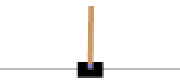

In [ ]:
from IPython.display import clear_output
import imageio
from IPython.display import Image
import cv2

num_episodes = 5000
plt.ion()

t_li = []

for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    frames= []
    for t in count():
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()

        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()
        # plt imshow in jupyter notebook update same figure
        # plt.imshow(
        #     get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation="none"
        # )
        frame = get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy()
        frame = (frame * 255).astype(np.uint8)
        frame = cv2.resize(frame, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_NEAREST)
        frames.append(frame)
        plt.axis("off")

        if done:
            clear_output(wait=True)
            print("버틴시간 리스트", t_li)
            print("현재 버틴 시간 ", t)
            episode_durations.append(t + 1)
            t_li.append(t + 1)
            imageio.mimsave('cartpole.gif', frames, fps=30)
            display(Image(filename="cartpole.gif"))
            break

    if i_episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print("Complete")

plt.title("화면")
env.render()
env.close()
plt.show()